In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import model_selection

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

regression_data_info = fetch_california_housing()
regression_feature_names = regression_data_info.feature_names

num_samples = 100
test_data_ratio = 0.3
random_state = 0
polynomial_degree = 1
epochs = 200
learning_rate = 5e-2

criterion = torch.nn.MSELoss()

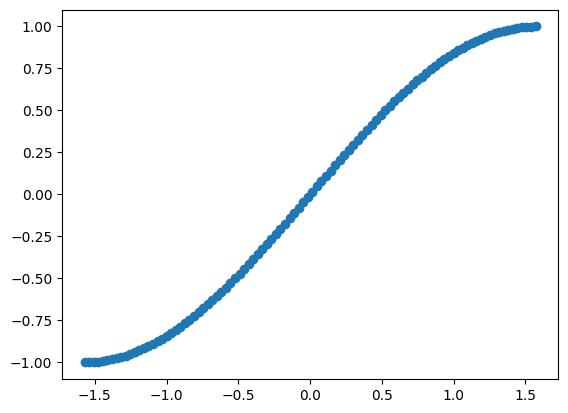

In [3]:
data = np.linspace(-np.pi/2, np.pi/2, num_samples).reshape(num_samples, 1)
label = np.sin(data)

idx = np.random.permutation(num_samples)

data = data[idx]
label = label[idx]

plt.scatter(data, label)
plt.show()

In [4]:
california_df = pd.DataFrame(regression_data_info.data, columns=regression_feature_names)
california_df['label'] = regression_data_info.target

california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,label
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
class SimpleDataLoader:
  def __init__(self, num_samples, test_data_ratio):
    self.num_samples = num_samples
    self.test_data_ratio = test_data_ratio

    self.data, self.label = self.get_dataset()
    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()
    self.standardize_data()

  def __call__(self, flag):
    if flag == 'train':
        return self.train_data, self.train_label
    else:
        return self.test_data, self.test_label

  def get_dataset(self):
    data = np.linspace(-np.pi/2, np.pi/2, self.num_samples).reshape(self.num_samples, 1)
    label = np.sin(data)

    idx = np.random.permutation(self.num_samples)

    data = data[idx]
    label = label[idx]

    return data, label

  def get_split_data(self):

    num_train_data = int(self.num_samples*(1-self.test_data_ratio))

    train_data, train_label = self.data[:num_train_data], self.label[:num_train_data]
    test_data, test_label = self.data[num_train_data:], self.label[num_train_data:]

    return train_data, train_label, test_data, test_label

  def standardize_data(self):
    mean = np.mean(self.train_data, axis=0)
    std = np.std(self.train_data, axis=0)

    self.train_data = (self.train_data - mean) / std
    self.test_data = (self.test_data - mean) / std

  def min_max_normalize_data(self):
    min = np.min(self.train_data, axis=0)
    max = np.max(self.train_data, axis=0)

    self.train_data = (self.train_data - min) / (max - min)
    self.test_data = (self.test_data - min) / (max - min)


class MultipleDataLoader:
  def __init__(self, data_info, feature_names, test_data_ratio, random_state):
    self.data_info = data_info
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.random_state = random_state

    self.data_infos = self.get_data_infos()
    self.data, self.label = self.get_dataset()

    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()
    self.standardize_data()
    # self.min_max_normalize_data()

  def __call__(self, flag):
    if flag == 'train':
        return self.train_data, self.train_label
    else:
        return self.test_data, self.test_label

  def get_data_infos(self):
    df = pd.DataFrame(self.data_info.data, columns=self.feature_names)
    df['label'] = self.data_info.target

    return df

  def get_dataset(self):
    data, label = self.data_infos.drop(columns=['label']), self.data_infos['label']

    return data, label

  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.data, self.label, test_size=self.test_data_ratio, random_state = self.random_state
    )
    return train_data.to_numpy(), train_label.to_numpy(), test_data.to_numpy(), test_label.to_numpy()

  def standardize_data(self):
    mean = np.mean(self.train_data, axis=0)
    std = np.std(self.train_data, axis=0)

    self.train_data = (self.train_data - mean) / std
    self.test_data = (self.test_data - mean) / std

  def min_max_normalize_data(self):
    min = np.min(self.train_data, axis=0)
    max = np.max(self.train_data, axis=0)

    self.train_data = (self.train_data - min) / (max - min)
    self.test_data = (self.test_data - min) / (max - min)


class DataProcessor:
  def __init__(self, polynomial_degree):
    self.polynomial_degree = polynomial_degree

  def __call__(self, data):
    num_samples = data.shape[0]

    bias_term = np.ones(num_samples).reshape(-1, 1)
    concat_data = bias_term

    for i in range(1, self.polynomial_degree + 1):
        concat_data = np.concatenate((concat_data, np.power(data, i)), axis=1)

    return concat_data

simple_dataloader = SimpleDataLoader(num_samples, test_data_ratio)
data_processor = DataProcessor(polynomial_degree)

simple_train_data, simple_train_label = simple_dataloader('train')
simple_test_data, simple_test_label = simple_dataloader('test')

simple_concat_train_data = data_processor(simple_train_data)
simple_concat_test_data = data_processor(simple_test_data)

multiple_dataloader = MultipleDataLoader(regression_data_info, regression_feature_names, test_data_ratio, random_state)
multiple_train_data, multiple_train_label = multiple_dataloader('train')
multiple_test_data, multiple_test_label = multiple_dataloader('test')

multiple_concat_train_data = data_processor(multiple_train_data)
multiple_concat_test_data = data_processor(multiple_test_data)

print(f'simple concat train data: {simple_concat_train_data.shape}/simple concat train label: {simple_train_label.shape}')
print(f'simple concat test data: {simple_concat_test_data.shape}/simple concat test label: {simple_test_label.shape}')

print(f'multiple concat train data: {multiple_concat_train_data.shape}/multiple concat train label: {multiple_train_label.shape}')
print(f'multiple concat test data: {multiple_concat_test_data.shape}/multiple concat test label: {multiple_test_label.shape}')

simple concat train data: (70, 2)/simple concat train label: (70, 1)
simple concat test data: (30, 2)/simple concat test label: (30, 1)
multiple concat train data: (14448, 9)/multiple concat train label: (14448,)
multiple concat test data: (6192, 9)/multiple concat test label: (6192,)


In [6]:
class TorchLinearRegression(nn.Module):
  def __init__(self, data):
    super(TorchLinearRegression, self).__init__()
    self.regressor = nn.Linear(data.shape[1], 1, bias=False)

  def forward(self, data):
    result = self.regressor(data)

    return result

  def get_params(self):
    param_list = list(self.regressor.parameters())

    weight = param_list[0][0, 1:].cpu().detach().numpy()
    bias = param_list[0][0, 0].cpu().detach().numpy()

    return weight, bias

class NumpyLinearRegression:
  def __init__(self):
    self.parameters = None

  def __call__(self, data):
    pred = data @ self.parameters

    return pred

  def get_params(self):
    np_weight, np_bias = self.parameters[1:], self.parameters[0]

    return np_weight, np_bias


simple_np_regressor = NumpyLinearRegression()
simple_torch_regressor = TorchLinearRegression(simple_concat_train_data).to(device)
simple_torch_model_optimizer = torch.optim.SGD(simple_torch_regressor.parameters(), lr =learning_rate)

multiple_np_regressor = NumpyLinearRegression()
multiple_torch_regressor = TorchLinearRegression(multiple_concat_train_data).to(device)
multiple_torch_model_optimizer = torch.optim.SGD(multiple_torch_regressor.parameters(), lr =learning_rate)

In [7]:
def train_numpy_model(data, label, model):
  model.parameters = np.linalg.inv(data.T @ data) @ data.T @ label

def train_torch_model(data, label, model, criterion, optimizer, epochs, device):
  model.train()

  data, label = torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)

  for epoch in range(epochs):
    optimizer.zero_grad()

    result = model(data)

    label = label.reshape(label.shape[0], 1)
    loss = criterion(result, label)

    loss.backward()
    optimizer.step()

train_numpy_model(simple_concat_train_data, simple_train_label, simple_np_regressor)
train_torch_model(simple_concat_train_data, simple_train_label, simple_torch_regressor, criterion, simple_torch_model_optimizer, epochs, device)

train_numpy_model(multiple_concat_train_data, multiple_train_label, multiple_np_regressor)
train_torch_model(multiple_concat_train_data, multiple_train_label, multiple_torch_regressor, criterion, multiple_torch_model_optimizer, epochs, device)

In [8]:
def show_parameters(np_model, torch_model):
    np_weight, np_bias = np_model.get_params()

    torch_weight, torch_bias = torch_model.get_params()

    print('np weight: {}\ntorch weight: {}'.format(np_weight, torch_weight))
    print('np bias: {}\ntorch bias: {}'.format(np_bias, torch_bias))


show_parameters(simple_np_regressor, simple_torch_regressor)
show_parameters(multiple_np_regressor, multiple_torch_regressor)

RuntimeError: Numpy is not available